## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import os
import datetime

import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path

import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from openslide import open_slide, __library_version__ as openslide_version

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

# Data Generation

## Patch Location Generator

This class serves as an (x, y), top left point, generator of each patch for training data and also test data. The shape of training and test data is 299x299. The label of the patch is defined by the center area of the patch with size of 128x128. If there exist one pixel tumor, the label will be 1, 0 otherwise. The patch generation is iterated from top left corner all the way to bottom right, with a certain sliding windows. For training set, the stride / sliding window is 128x128 and test set is 299x299. The reason for both value is because I don't want to overlook positive samples in the training set and for the convenience of creating the heatmap for test set.

In [5]:
import os
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.patches as plt_patches
from PIL import Image

class PatchLocationDataset():
  def __init__(self, tumor_paths, tumor_mask_paths, level, 
               gray_threshold=3, patch_size=(299,299), center_size=(128,128)):
    self.tumor_paths = tumor_paths
    self.tumor_mask_paths = tumor_mask_paths
    self.level = level
    self.patch_size = patch_size
    self.center_size = center_size
    self.gray_threshold = gray_threshold

  def generate_training_patches(self, slide, tumor_mask):
    slide_image = read_slide(slide, 
                            x=0, 
                            y=0, 
                            level=self.level,
                            width=slide.level_dimensions[self.level][0], 
                            height=slide.level_dimensions[self.level][1])
    mask_image = read_slide(tumor_mask, 
                            x=0, 
                            y=0, 
                            level=self.level, 
                            width=tumor_mask.level_dimensions[self.level][0], 
                            height=tumor_mask.level_dimensions[self.level][1])
    
    mask_image = mask_image[:,:,0]

    labels = []
    patches = []

    x = 0
    y = 0
    # iterate through slides
    while (x + self.patch_size[0]) < slide.level_dimensions[self.level][0]:
      while (y + self.patch_size[1]) < slide.level_dimensions[self.level][1]:
        cropped_image = read_slide(
          slide, 
          x=x * int(slide.level_downsamples[self.level]), 
          y=y * int(slide.level_downsamples[self.level]), 
          level=self.level,
          width=self.patch_size[0], 
          height=self.patch_size[1]
        )
        
        # Skip all gray image
        tissue_pixels = find_tissue_pixels(cropped_image)
        percent_tissue = len(tissue_pixels) / float(cropped_image.shape[0] * cropped_image.shape[0]) * 100
        if (percent_tissue < self.gray_threshold):
          y += self.center_size[1]
          continue
        
        x_c = x + (self.patch_size[0] - self.center_size[0]) // 2
        y_c = y + (self.patch_size[1] - self.center_size[1]) // 2
        if 1 in mask_image[y_c:y_c+self.center_size[1], x_c:x_c+self.center_size[0]]:
          patches.append([x, y])
          labels.append(1.)
        else:
          patches.append([x, y])
          labels.append(0.)

        y += self.center_size[1]
      x += self.center_size[0]
      y = 0

    patches = np.array(patches)
    labels = np.array(labels)
    return patches, labels

  def generate_test_patches(self, slide, tumor_mask):
    slide_image = read_slide(slide, 
                            x=0, 
                            y=0, 
                            level=self.level,
                            width=slide.level_dimensions[self.level][0], 
                            height=slide.level_dimensions[self.level][1])
    mask_image = read_slide(tumor_mask, 
                            x=0, 
                            y=0, 
                            level=self.level, 
                            width=tumor_mask.level_dimensions[self.level][0], 
                            height=tumor_mask.level_dimensions[self.level][1])
    
    mask_image = mask_image[:,:,0]

    labels = []
    patches = []

    x = 0
    y = 0
    # iterate through slides
    while (x + self.patch_size[0]) < slide.level_dimensions[self.level][0]:
      while (y + self.patch_size[1]) < slide.level_dimensions[self.level][1]:
        cropped_image = read_slide(
          slide, 
          x=x * int(slide.level_downsamples[self.level]), 
          y=y * int(slide.level_downsamples[self.level]), 
          level=self.level,
          width=self.patch_size[0], 
          height=self.patch_size[1]
        )
        
        # Skip all gray image
        tissue_pixels = find_tissue_pixels(cropped_image)
        percent_tissue = len(tissue_pixels) / float(cropped_image.shape[0] * cropped_image.shape[0]) * 100
        if (percent_tissue < self.gray_threshold):
          y += self.patch_size[1]
          continue
        
        x_c = x + (self.patch_size[0] - self.center_size[0]) // 2
        y_c = y + (self.patch_size[1] - self.center_size[1]) // 2
        if 1 in mask_image[y_c:y_c+self.center_size[1], x_c:x_c+self.center_size[0]]:
          patches.append([x, y])
          labels.append(1.)
        else:
          patches.append([x, y])
          labels.append(0.)

        y += self.patch_size[1]
      x += self.patch_size[0]
      y = 0

    patches = np.array(patches)
    labels = np.array(labels)
    return patches, labels

  def generate_location_dataset(self, test_mode=False):
    all_patches = np.array([])
    all_labels = np.array([])
    for i, tumor_path in enumerate(self.tumor_paths):
      slide = open_slide(tumor_path)
      tumor_mask = open_slide(self.tumor_mask_paths[i])

      if test_mode:
        patches, labels = self.generate_test_patches(slide, tumor_mask)
      else:
        patches, labels = self.generate_training_patches(slide, tumor_mask)
      
      tumor_indices = np.squeeze(np.argwhere(labels == 1), axis=1)
      healthy_indices = np.squeeze(np.argwhere(labels == 0), axis=1)
      print(tumor_indices.shape[0], healthy_indices.shape[0])
      
      slide_idx = np.full((labels.shape[0], 1), i)
      patches = np.concatenate((patches, slide_idx), axis=1)
      
      if all_patches.shape[0] == 0:
        all_patches = patches
        all_labels = labels
      else:
        all_patches = np.concatenate((all_patches, patches), axis=0)
        all_labels = np.concatenate((all_labels, labels), axis=0)
    return all_patches, all_labels

In [6]:
# Use 3 slides for training & val set
tumor_paths = [
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_075.tif',
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_078.tif',
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_110.tif'
]
tumor_mask_paths = [
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_075_mask.tif',
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_078_mask.tif',
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_110_mask.tif'
]

level = 3
magnification = 1
big_level = level + magnification
patch_size = (299, 299)
slides = [open_slide(tumor_path) for tumor_path in tumor_paths]
slide_images = []
slide_dimensions = []
big_slide_images = []
big_slide_dimensions = []
scales = []

for slide in slides:
  slide_image = read_slide(
      slide, 
      x=0, 
      y=0, 
      level=level,
      width=slide.level_dimensions[level][0], 
      height=slide.level_dimensions[level][1]
  )
  slide_images.append(slide_image)
  slide_dimensions.append([slide.level_dimensions[level][0],
                           slide.level_dimensions[level][1]])

  big_slide_image = read_slide(
      slide, 
      x=0, 
      y=0, 
      level=big_level,
      width=slide.level_dimensions[big_level][0], 
      height=slide.level_dimensions[big_level][1]
  )
  big_slide_images.append(big_slide_image)
  big_slide_dimensions.append([slide.level_dimensions[big_level][0],
                              slide.level_dimensions[big_level][1]])
  
  scale = float(slide.level_downsamples[level]) / float(slide.level_downsamples[big_level])
  scales.append(scale)

dataset_generator = PatchLocationDataset(
    tumor_paths=tumor_paths, 
    tumor_mask_paths=tumor_mask_paths, 
    level=level,
    gray_threshold=1,
)
patches, labels = dataset_generator.generate_location_dataset()

130 3436
1395 4656
1245 2278


## Image Generator Module

Here are some functionalities covered in this module
- Generating images for one scale model
- Generating images for multiscale model
  - The idea is to create two images of each scale with the same size (299,299), and then concat it as one image with size of (299,598).
- Image augmentation
  - Flip horizontal and vertical
  - Rotate 90, 180, 270

In [7]:
!rm -r dataset_multiscale/
!rm -r dataset_onescale/

In [8]:
def image_augmentation(image, n=3):
  augmentation_indices = np.random.randint(6, size=n)
  augmented_images = []
  for idx in augmentation_indices:
    if idx < 4:
      rotated = np.rot90(image, k=idx+1)
      augmented_images.append(rotated)
    else:
      flipped_image = np.flip(image, axis=idx%2)
      augmented_images.append(flipped_image)
  
  return augmented_images

def write_image(image, dir_path, slide_idx, img_id, augmentation=False):
  if augmentation:
    augmented_images = image_augmentation(image)
    for j, augmented_image in enumerate(augmented_images):
      im = Image.fromarray(augmented_image)
      im.save("{}{}_{}_{}.jpg".format(dir_path, slide_idx, img_id, j))
  else:
    im = Image.fromarray(image)
    im.save("{}{}_{}.jpg".format(dir_path, slide_idx, img_id))

def write_multiscale_image(image_small, image_big, dir_path, slide_idx, img_id, augmentation=False):
  if augmentation:
    augmented_images_small = image_augmentation(image_small)
    augmented_images_big = image_augmentation(image_big)
    for j, augmented_image_small in enumerate(augmented_images_small):
      augmented_image_big = augmented_images_big[j]
      combined = np.concatenate((augmented_image_small, augmented_image_big), axis=1)
      im = Image.fromarray(combined)
      im.save("{}{}_{}_{}.jpg".format(dir_path, slide_idx, img_id, j))
  else:
    combined = np.concatenate((image_small, image_big), axis=1)
    im = Image.fromarray(combined)
    im.save("{}{}_{}.jpg".format(dir_path, slide_idx, img_id))

def generate_training_images(patches, labels, patch_size=(299,299)):
  tumor_dataset_path = 'dataset_onescale/tumor/'
  healthy_dataset_path = 'dataset_onescale/healthy/'

  path = Path(tumor_dataset_path)
  if not os.path.exists(tumor_dataset_path):
    path.mkdir(parents=True)
  path = Path(healthy_dataset_path)
  if not os.path.exists(healthy_dataset_path):
    path.mkdir(parents=True)

  for i, patch in enumerate(patches):
    x, y, slide_idx = patch
  
    slide_image = slide_images[slide_idx]
    slide_height = slide_dimensions[slide_idx][1]
    slide_width = slide_dimensions[slide_idx][0]
    
    image = slide_image[y:y+patch_size[1], x:x+patch_size[0]]
    if labels[i] == 1:
      write_image(image, tumor_dataset_path, slide_idx, i, augmentation=True)
    else:
      write_image(image, healthy_dataset_path, slide_idx, i, augmentation=False)

def generate_training_multiscale_images(patches, labels, patch_size=(299,299)):
  tumor_dataset_path = 'dataset_multiscale/tumor/'
  healthy_dataset_path = 'dataset_multiscale/healthy/'

  path = Path(tumor_dataset_path)
  if not os.path.exists(tumor_dataset_path):
    path.mkdir(parents=True)
  path = Path(healthy_dataset_path)
  if not os.path.exists(healthy_dataset_path):
    path.mkdir(parents=True)

  for i, patch in enumerate(patches):
    x, y, slide_idx = patch

    slide_image = slide_images[slide_idx]
    big_slide_image = big_slide_images[slide_idx]
    big_slide_height = big_slide_dimensions[slide_idx][1]
    big_slide_width = big_slide_dimensions[slide_idx][0]
    scale = scales[slide_idx]

    image = slide_image[y:y+patch_size[1], x:x+patch_size[1]]
    
    x_center = x + patch_size[0] // 2
    y_center = y + patch_size[1] // 2
    big_x = int(max(float(x_center) * scale - float(patch_size[0]) / 2., 0.))
    big_y = int(max(float(y_center) * scale - float(patch_size[1]) / 2., 0.))
  
    height = min(big_slide_height, big_y + patch_size[0]) - big_y
    width = min(big_slide_width, big_x + patch_size[1]) - big_x

    big_image = big_slide_image[big_y:big_y+height, big_x:big_x+width]
    big_image = Image.fromarray(big_image)
    big_image = big_image.resize(size=patch_size)
    big_image = np.asarray(big_image)

    if labels[i] == 1:
      write_multiscale_image(image, big_image, tumor_dataset_path, 
                             slide_idx, i, augmentation=True)
    else:
      write_multiscale_image(image, big_image, healthy_dataset_path, 
                             slide_idx, i, augmentation=False)

In [9]:
generate_training_images(patches, labels, patch_size=(299,299))
generate_training_multiscale_images(patches, labels, patch_size=(299,299))

In [10]:
!ls dataset_onescale/tumor/ | wc -l
!ls dataset_onescale/healthy/ | wc -l
!ls dataset_multiscale/tumor/ | wc -l
!ls dataset_multiscale/healthy/ | wc -l

8310
10370
8310
10370


## tf.data.Dataset Preparation

This sections instansiated the tf.data.Dataset for one scale model and multiscale model. Note that for multiscale model, we need to do a preprocessing to split the previously combined multiscaled image, and then stack it so the form will be easier to decompose on tf.Model call.

In [11]:
# For multiscale only
def preprocess(image, label):
  small_image, big_image = tf.split(image, num_or_size_splits=2, axis=2)
  combined_image = tf.stack((small_image, big_image), axis=1)
  return combined_image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000

data_dir = 'dataset_onescale/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(299, 299),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(299, 299),
  batch_size=BATCH_SIZE)

data_dir = 'dataset_multiscale/'

multiscale_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(299, 598),
  batch_size=BATCH_SIZE)

multiscale_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(299, 598),
  batch_size=BATCH_SIZE)

multiscale_train_ds = multiscale_train_ds.map(preprocess)
multiscale_val_ds = multiscale_val_ds.map(preprocess)

Found 18680 files belonging to 2 classes.
Using 14944 files for training.
Found 18680 files belonging to 2 classes.
Using 3736 files for validation.
Found 18680 files belonging to 2 classes.
Using 14944 files for training.
Found 18680 files belonging to 2 classes.
Using 3736 files for validation.


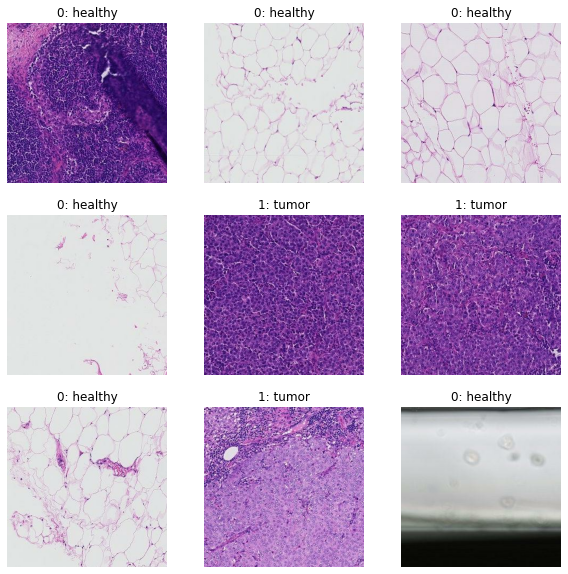

In [12]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

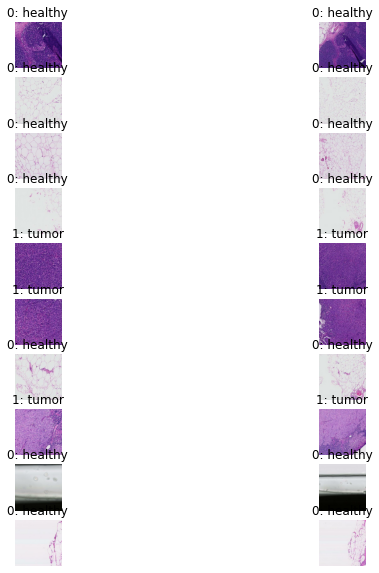

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in multiscale_train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(10, 2, i*2 + 1)
    plt.imshow(images[i][0].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

    ax = plt.subplot(10, 2, i*2 + 2)
    plt.imshow(images[i][1].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

# Model Training

## One Scale Model Definition

The model consists of mobilenet preprocess input layer to normalize the pixel value to be between 0 to 1, imagenet pretrained mobile net layer, and dense layer.

Hyperparameter tuning is done by 'grad student descent' approach with only changing the size of dense layer. Since the model inherently already performed well, I focused on reducing model complexity, choosing smallest acceptable dense layer size.

In [14]:
class OneScaleModel(tf.keras.Model):
  def __init__(
      self,
      name="one_scale_model",
      **kwargs
  ):
    super(OneScaleModel, self).__init__()
    
    self.normalizer_layer = tf.keras.applications.mobilenet_v2.preprocess_input
    self.mobilenet_v2_layer = tf.keras.applications.MobileNetV2(
      input_shape=(299, 299, 3),
      include_top=False,
      weights='imagenet'
    )

    self.dense_layer = tf.keras.Sequential([
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ], name="dense_layer")
      
  def call(self, inputs):
    outputs = self.normalizer_layer(inputs)
    outputs = self.mobilenet_v2_layer(outputs)
    outputs = self.dense_layer(outputs)
    
    return outputs

In [15]:
onescale_model = OneScaleModel()

onescale_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model_dir = "models/onescale/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(model_dir)

onescale_model_path = model_dir + "/best_model.tf"
save_best = ModelCheckpoint(onescale_model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 15
history = onescale_model.fit(train_ds,
                            epochs=epochs,
                            validation_data=val_ds,
                            callbacks=[stop_early, save_best])


Epoch 1/15
467/467 [==============================] - 178s 368ms/step - loss: 0.1507 - accuracy: 0.9418 - val_loss: 13.0113 - val_accuracy: 0.5530

Epoch 00001: val_loss improved from inf to 13.01134, saving model to models/onescale/20210429-164819/best_model.tf
Epoch 2/15
467/467 [==============================] - 169s 362ms/step - loss: 0.0583 - accuracy: 0.9804 - val_loss: 1.3330 - val_accuracy: 0.6962

Epoch 00002: val_loss improved from 13.01134 to 1.33304, saving model to models/onescale/20210429-164819/best_model.tf
Epoch 3/15
467/467 [==============================] - 170s 363ms/step - loss: 0.0408 - accuracy: 0.9853 - val_loss: 0.1539 - val_accuracy: 0.9631

Epoch 00003: val_loss improved from 1.33304 to 0.15388, saving model to models/onescale/20210429-164819/best_model.tf
Epoch 4/15
467/467 [==============================] - 169s 361ms/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.1639 - val_accuracy: 0.9615

Epoch 00004: val_loss did not improve from 0.15388
Epoch 5/

## Multi Scale Model Definition

The model consists two identical submodels and ensembling dense layer. Each of submodel consists of mobilenet preprocess input layer to normalize the pixel value to be between 0 to 1, imagenet pretrained mobile net layer, and dense layer.

Hyperparameter tuning is done by 'grad student descent' approach and the biggest improvement on val accuracy is by changing flatten into global average pooling. It is reasonable since it reduces complexity preventing from overfit.

In [16]:
class MultiScaleModel(tf.keras.Model):
  def __init__(
      self,
      name="multi_scale_model",
      **kwargs
  ):
    super(MultiScaleModel, self).__init__()
    
    # Normalize by / 255.0
    self.normalizer_layer = tf.keras.applications.mobilenet_v2.preprocess_input
    self.small_mobilenet_v2_layer = tf.keras.applications.MobileNetV2(
      input_shape=(299, 299, 3),
      include_top=False,
      weights='imagenet'
    )
    self.small_pooling_layer = tf.keras.Sequential([
      tf.keras.layers.GlobalAveragePooling2D()
    ], name="small_pooling_layer")

    self.big_mobilenet_v2_layer = tf.keras.applications.MobileNetV2(
      input_shape=(299, 299, 3),
      include_top=False,
      weights='imagenet'
    )
    self.big_pooling_layer = tf.keras.Sequential([
      tf.keras.layers.GlobalAveragePooling2D()
    ], name="big_pooling_layer")

    self.ensembling_layers = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.2),     
      tf.keras.layers.Dense(1, activation='sigmoid')
    ], name='ensembling_layers')
      
  def call(self, inputs):
    """
        Args:
            inputs: 2-D float `Tensor` of one-hot nucleotides encoded embedding. 
                The one-hot nucleotides embedding is a concatenation of rna_seq 
                and grna_seq pair embedding. [batch, rna_length + grna_length]
        Returns:
            outputs: 3-D float `Tensor` of representational embedding of rna and grna.
                [batch, 2, embedding_dim]
    """
    small_features = self.normalizer_layer(inputs[:, 0])
    small_features = self.small_mobilenet_v2_layer(small_features)
    small_features = self.small_pooling_layer(small_features)

    big_features = self.normalizer_layer(inputs[:, 1])
    big_features = self.big_mobilenet_v2_layer(big_features)
    big_features = self.big_pooling_layer(big_features)

    aggregated_features = tf.concat((small_features, big_features), axis=1)
    outputs = self.ensembling_layers(aggregated_features)
    
    return outputs

In [17]:
import datetime
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

multiscale_model = MultiScaleModel()

multiscale_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model_dir = "models/multiscale/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(model_dir)

multiscale_model_path = model_dir + "/best_model.tf"
save_best = ModelCheckpoint(multiscale_model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 15
history = multiscale_model.fit(multiscale_train_ds,
                              epochs=epochs,
                              validation_data=multiscale_val_ds,
                              callbacks=[stop_early, save_best])


Epoch 1/15
467/467 [==============================] - 362s 758ms/step - loss: 0.1600 - accuracy: 0.9396 - val_loss: 3.0188 - val_accuracy: 0.4574

Epoch 00001: val_loss improved from inf to 3.01885, saving model to models/multiscale/20210429-173050/best_model.tf
Epoch 2/15
467/467 [==============================] - 354s 757ms/step - loss: 0.0788 - accuracy: 0.9718 - val_loss: 1.3005 - val_accuracy: 0.6753

Epoch 00002: val_loss improved from 3.01885 to 1.30052, saving model to models/multiscale/20210429-173050/best_model.tf
Epoch 3/15
467/467 [==============================] - 353s 754ms/step - loss: 0.0428 - accuracy: 0.9848 - val_loss: 0.3581 - val_accuracy: 0.8260

Epoch 00003: val_loss improved from 1.30052 to 0.35813, saving model to models/multiscale/20210429-173050/best_model.tf
Epoch 4/15
467/467 [==============================] - 354s 757ms/step - loss: 0.0344 - accuracy: 0.9873 - val_loss: 1.6625 - val_accuracy: 0.7053

Epoch 00004: val_loss did not improve from 0.35813
Epoch

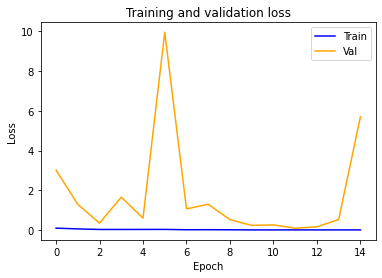

In [61]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(loss))

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

# Result

## Generate Test Data

This section covers test data generation which is similar to the method on Data Generation section. There is a little modification because we want the output to be patch location, image, and label.

In [55]:
def write_test_image(image, dir_path, img_id):
  im = Image.fromarray(image)
  im.save("{}{:05d}.jpg".format(dir_path, img_id))

def write_test_multiscale_image(image_small, image_big, dir_path, img_id):
  combined = np.concatenate((image_small, image_big), axis=1)
  im = Image.fromarray(combined)
  im.save("{}{:05d}.jpg".format(dir_path, img_id))

def generate_test_images(patches, tumor_path, dataset_path, patch_size=(299,299)):
  slide = open_slide(tumor_path)
  slide_image = read_slide(
      slide, 
      x=0, 
      y=0, 
      level=level,
      width=slide.level_dimensions[level][0], 
      height=slide.level_dimensions[level][1]
  )
  
  path = Path(dataset_path)
  if not os.path.exists(dataset_path):
    path.mkdir(parents=True)
  
  for i, patch in enumerate(patches):
    x, y, _ = patch
  
    image = slide_image[y:y+patch_size[1], x:x+patch_size[0]]
    write_test_image(image, dataset_path, i)
    
def generate_test_multiscale_images(patches, tumor_path, dataset_path, patch_size=(299,299)):
  slide = open_slide(tumor_path)
  slide_image = read_slide(
      slide, 
      x=0, 
      y=0, 
      level=level,
      width=slide.level_dimensions[level][0], 
      height=slide.level_dimensions[level][1]
  )
  
  big_slide_image = read_slide(
      slide, 
      x=0, 
      y=0, 
      level=big_level,
      width=slide.level_dimensions[big_level][0], 
      height=slide.level_dimensions[big_level][1]
  )
  slide_width = slide.level_dimensions[level][0]
  slide_height = slide.level_dimensions[level][1]
  big_slide_width = slide.level_dimensions[big_level][0]
  big_slide_height = slide.level_dimensions[big_level][1]
  scale = float(slide.level_downsamples[level]) / float(slide.level_downsamples[big_level])
  
  path = Path(dataset_path)
  if not os.path.exists(dataset_path):
    path.mkdir(parents=True)

  for i, patch in enumerate(patches):
    x, y, _ = patch

    image = slide_image[y:y+patch_size[1], x:x+patch_size[1]]
    
    x_center = x + patch_size[0] // 2
    y_center = y + patch_size[1] // 2
    big_x = int(max(float(x_center) * scale - float(patch_size[0]) / 2., 0.))
    big_y = int(max(float(y_center) * scale - float(patch_size[1]) / 2., 0.))
  
    height = min(big_slide_height, big_y + patch_size[0]) - big_y
    width = min(big_slide_width, big_x + patch_size[1]) - big_x

    big_image = big_slide_image[big_y:big_y+height, big_x:big_x+width]
    big_image = Image.fromarray(big_image)
    big_image = big_image.resize(size=patch_size)
    big_image = np.asarray(big_image)

    write_test_multiscale_image(image, big_image, dataset_path, i)

def preprocess(image, label):
  small_image, big_image = tf.split(image, num_or_size_splits=2, axis=2)
  combined_image = tf.stack((small_image, big_image), axis=1)
  return combined_image, label

### Generate Seen Data

This section generates test dataset from slide 78 or partially seen data. Later on we will compare with unseen data result.

In [56]:
!rm -r onescale_test_78/
!rm -r multiscale_test_78/

In [57]:
tumor_paths = [
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_078.tif',
]
tumor_mask_paths = [
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_078_mask.tif',
]

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
level = 3
big_level = 4

dataset_generator = PatchLocationDataset(
    tumor_paths=tumor_paths, 
    tumor_mask_paths=tumor_mask_paths, 
    level=level,
    gray_threshold=1
)
seen_test_patches, seen_test_labels = dataset_generator.generate_location_dataset(test_mode=True)

onescale_dir = 'onescale_test_78/78/'
multiscale_dir = 'multiscale_test_78/78/'
generate_test_images(seen_test_patches, tumor_paths[0], onescale_dir)
generate_test_multiscale_images(seen_test_patches, tumor_paths[0], multiscale_dir)

data_dir = 'onescale_test_78/'
seen_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=False,
  image_size=(299, 299),
  batch_size=BATCH_SIZE
)

data_dir = 'multiscale_test_78/'
seen_multiscale_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=False,
  image_size=(299, 598),
  batch_size=BATCH_SIZE
)
seen_multiscale_test_ds = seen_multiscale_test_ds.map(preprocess)

slide = open_slide(tumor_paths[0])
seen_test_slide_image = read_slide(
    slide,
    x=0,
    y=0,
    level=level,
    width=slide.level_dimensions[level][0],
    height=slide.level_dimensions[level][1]
)

tumor_mask = open_slide(tumor_mask_paths[0])
seen_test_mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0], 
                        height=tumor_mask.level_dimensions[level][1])

seen_test_mask_image = seen_test_mask_image[:,:,0]

252 876
Found 1128 files belonging to 1 classes.
Found 1128 files belonging to 1 classes.
Tensor("stack:0", shape=(None, 2, 299, 299, 3), dtype=float32)


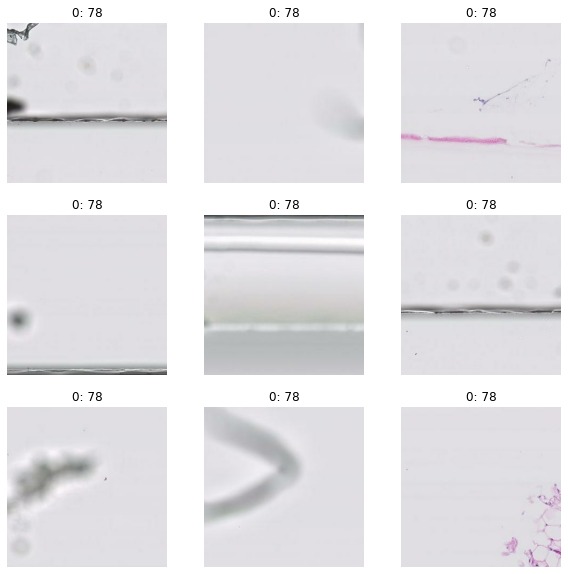

In [36]:
class_names = seen_test_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in seen_test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

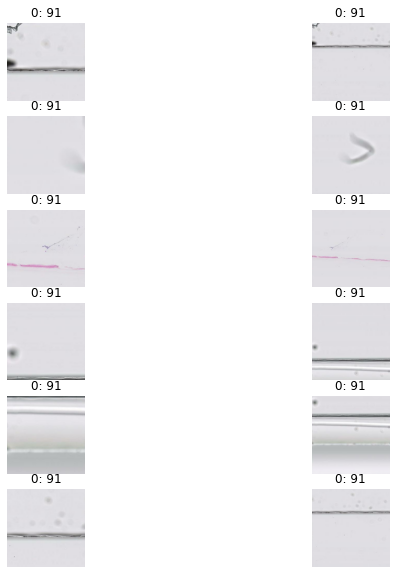

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in seen_multiscale_test_ds.take(1):
  for i in range(6):
    ax = plt.subplot(6, 2, i*2 + 1)
    plt.imshow(images[i][0].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")
    ax = plt.subplot(6, 2, i*2 + 2)
    plt.imshow(images[i][1].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

In [37]:
!ls onescale_test_78/78/ | wc -l
!ls multiscale_test_78/78/ | wc -l

1128
1128


### Generate Unseen Data

In [38]:
!rm -r onescale_test_91/
!rm -r multiscale_test_91/

rm: cannot remove 'onescale_test_91/': No such file or directory
rm: cannot remove 'multiscale_test_91/': No such file or directory


In [39]:
tumor_paths = [
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_091.tif',
]
tumor_mask_paths = [
  '/content/drive/MyDrive/COMS4995_Applied_Deep_Learning/Project/slides/tumor_091_mask.tif',
]

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
level = 3
big_level = 4

dataset_generator = PatchLocationDataset(
    tumor_paths=tumor_paths, 
    tumor_mask_paths=tumor_mask_paths, 
    level=level,
    gray_threshold=1
)
unseen_test_patches, unseen_test_labels = dataset_generator.generate_location_dataset(test_mode=True)

onescale_dir = 'onescale_test_91/91/'
multiscale_dir = 'multiscale_test_91/91/'
generate_test_images(unseen_test_patches, tumor_paths[0], onescale_dir)
generate_test_multiscale_images(unseen_test_patches, tumor_paths[0], multiscale_dir)

data_dir = 'onescale_test_91/'
unseen_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=False,
  image_size=(299, 299),
  batch_size=BATCH_SIZE
)

data_dir = 'multiscale_test_91/'
unseen_multiscale_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=False,
  image_size=(299, 598),
  batch_size=BATCH_SIZE
)
unseen_multiscale_test_ds = unseen_multiscale_test_ds.map(preprocess)

slide = open_slide(tumor_paths[0])
unseen_test_slide_image = read_slide(
    slide,
    x=0,
    y=0,
    level=level,
    width=slide.level_dimensions[level][0],
    height=slide.level_dimensions[level][1]
)

tumor_mask = open_slide(tumor_mask_paths[0])
unseen_test_mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0], 
                        height=tumor_mask.level_dimensions[level][1])

unseen_test_mask_image = unseen_test_mask_image[:,:,0]

16 254
Found 270 files belonging to 1 classes.
Found 270 files belonging to 1 classes.


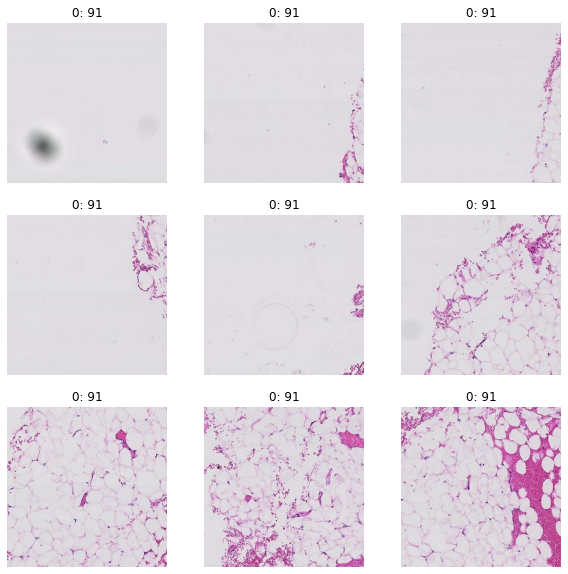

In [40]:
class_names = unseen_test_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in unseen_test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

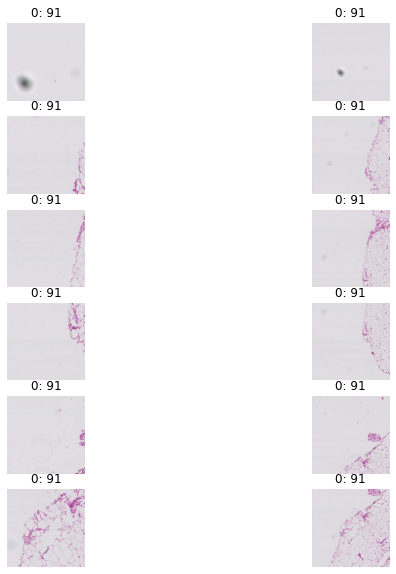

In [51]:
plt.figure(figsize=(10, 10))
for images, labels in unseen_multiscale_test_ds.take(1):
  for i in range(6):
    ax = plt.subplot(6, 2, i*2 + 1)
    plt.imshow(images[i][0].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")
    ax = plt.subplot(6, 2, i*2 + 2)
    plt.imshow(images[i][1].numpy().astype("uint8"))
    plt.title("{}: {}".format(labels[i], class_names[labels[i]]))
    plt.axis("off")

In [41]:
!ls onescale_test_91/91/ | wc -l
!ls multiscale_test_91/91/ | wc -l

270
270


## Prediction

This method will do prediction, metric calculation, and also heatmap visualization.

In [52]:
def predict(model, slide_image, mask_image, patches, 
            images, labels, patch_size=(299,299)):
  y_pred = np.squeeze(model.predict(images), axis=1)
  
  acc = accuracy_score(labels, y_pred.astype(int))
  roc = roc_auc_score(labels, y_pred.astype(int))
  prec = precision_score(labels, y_pred.astype(int))
  rec = recall_score(labels, y_pred.astype(int))
  f1 = f1_score(labels, y_pred.astype(int))

  print("Accuracy: {}\nROC: {}\nPrecision: {}\nRecall: {}\nF1 Score: {}".format(
      acc, roc, prec, rec, f1
  ))

  print("Slide level prediction: {}% contains tumor".format(int(max(y_pred) * 100)))

  heatmap = np.zeros((mask_image.shape[0], mask_image.shape[1], 3), dtype=np.uint8)
  for i, label in enumerate(y_pred):
    x = patches[i][0]
    y = patches[i][1]
    if label > 0.5:
      heatmap[y:y+patch_size[1], x:x+patch_size[0], 0] = int(255.0 * label)
  
  height, width, _ = slide_image.shape
  new_height = int(height * 0.1)
  new_width = int(width * 0.1)

  slide_image = Image.fromarray(slide_image)
  slide_image = slide_image.resize(size=(new_height, new_width))
  slide_image = np.asarray(slide_image)
  
  heatmap = Image.fromarray(heatmap)
  heatmap = heatmap.resize(size=(new_height, new_width))
  heatmap = np.asarray(heatmap)
  
  mask_image = Image.fromarray(np.uint8(mask_image * 255), 'L')
  mask_image = mask_image.resize(size=(new_height, new_width))
  mask_image = np.asarray(mask_image)
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(heatmap, alpha=0.5)
  plt.imshow(mask_image, cmap='GnBu', alpha=0.5)

### Prediction on Seen Data

Below is the prediction, metric, and heatmap visualization of one scale and multi scale model on slide no 78 / partially seen dataset.

Accuracy: 0.9219858156028369
ROC: 0.8253968253968254
Precision: 1.0
Recall: 0.6507936507936508
F1 Score: 0.7884615384615385
Slide level prediction: 100% contains tumor


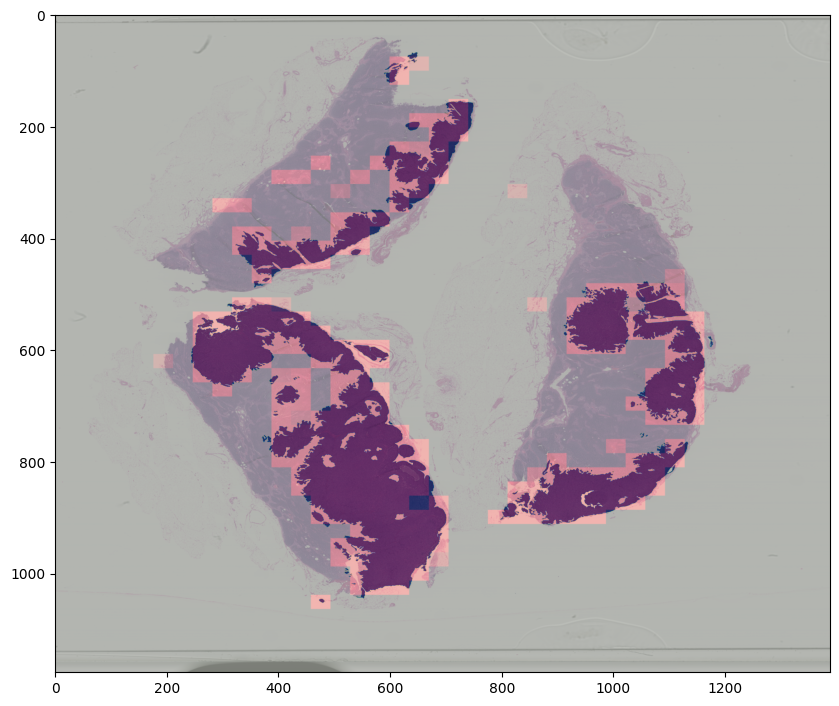

In [48]:
# onescale_model_path = '' # edit this
onescale_model = OneScaleModel()
onescale_model.load_weights(onescale_model_path)

predict(onescale_model, seen_test_slide_image, seen_test_mask_image, 
        seen_test_patches, seen_test_ds, seen_test_labels)

Accuracy: 0.850177304964539
ROC: 0.6646825396825397
Precision: 1.0
Recall: 0.32936507936507936
F1 Score: 0.4955223880597015
Slide level prediction: 100% contains tumor


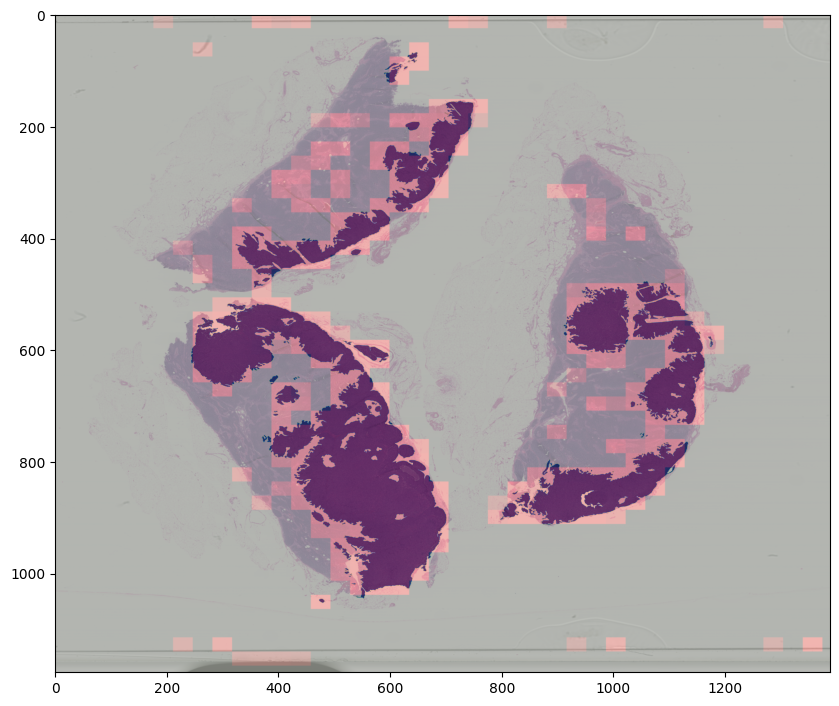

In [59]:
# multiscale_model_path = '' # edit this
multiscale_model = MultiScaleModel()
multiscale_model.load_weights(multiscale_model_path)

predict(multiscale_model, seen_test_slide_image, seen_test_mask_image, 
        seen_test_patches, seen_multiscale_test_ds, seen_test_labels)

### Prediction on Unseen Data

Below is the prediction, metric, and heatmap visualization of one scale and multi scale model on slide no 91 / unseen dataset.

Accuracy: 0.9703703703703703
ROC: 0.75
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Slide level prediction: 100% contains tumor


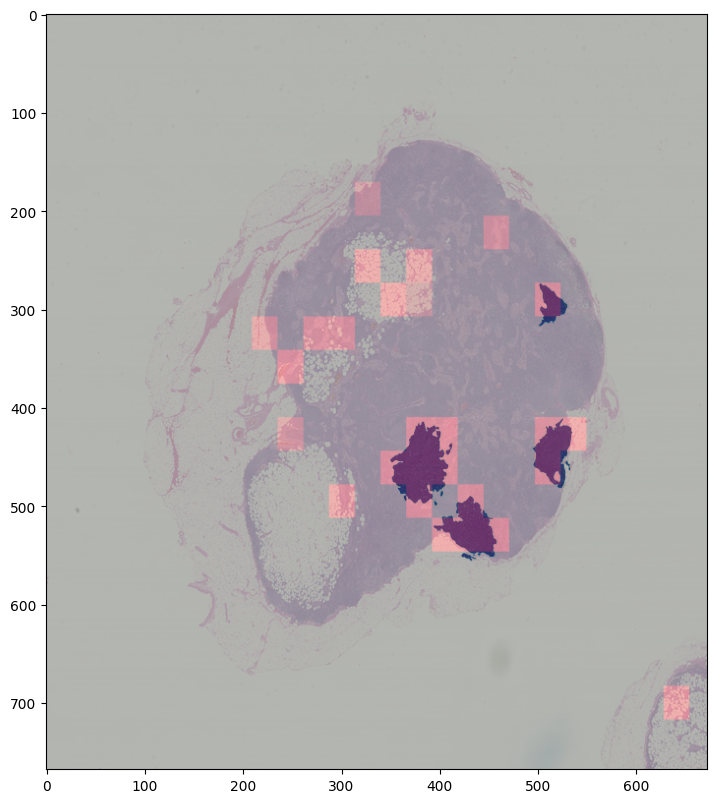

In [53]:
# onescale_model_path = '' # edit this
onescale_model = OneScaleModel()
onescale_model.load_weights(onescale_model_path)

predict(onescale_model, unseen_test_slide_image, unseen_test_mask_image, 
        unseen_test_patches, unseen_test_ds, unseen_test_labels)

Accuracy: 0.9481481481481482
ROC: 0.5625
Precision: 1.0
Recall: 0.125
F1 Score: 0.2222222222222222
Slide level prediction: 100% contains tumor


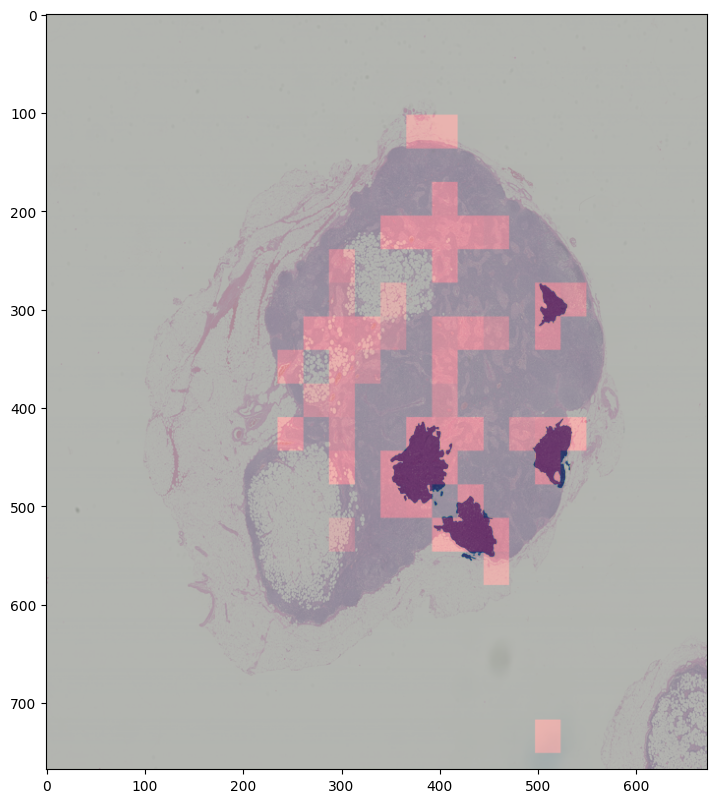

In [60]:
# multiscale_model_path = '' # edit this
multiscale_model = MultiScaleModel()
multiscale_model.load_weights(multiscale_model_path)

predict(multiscale_model, unseen_test_slide_image, unseen_test_mask_image, 
        unseen_test_patches, unseen_multiscale_test_ds, unseen_test_labels)

As illustrated by the results above, on both unseen and seen dataset, the multiscale model yields more false positives hence lower ROC, F1, and recall score. The intuition here is probably due to wider range of view, the big scale images can't avoid overlapped label images that confuses the predictor.

At first, the model is stuck with either all zeros prediction or all ones prediction due to data imbalance. After I implemented the image augmentation the model started to learn as expected, which gives the current result.

Lastly, both models are able to get 100% in precision, zero false negative which is suitable for practical use case. In real case, we penalizes more on false negative for cancer detection.

# Downloading the Model

In [45]:
print(multiscale_model_path)
print(onescale_model_path)

models/multiscale/20210429-173050/best_model.tf
models/onescale/20210429-164819/best_model.tf


In [46]:
!zip -r multiscale_best_model.zip /content/models/multiscale/20210429-173050/
!zip -r onescale_best_model.zip /content/models/onescale/20210429-164819/

updating: content/models/multiscale/20210429-173050/ (stored 0%)
updating: content/models/multiscale/20210429-173050/checkpoint (deflated 41%)
updating: content/models/multiscale/20210429-173050/best_model.tf.index (deflated 81%)
updating: content/models/multiscale/20210429-173050/best_model.tf.data-00000-of-00001 (deflated 9%)
updating: content/models/onescale/20210429-164819/ (stored 0%)
updating: content/models/onescale/20210429-164819/checkpoint (deflated 41%)
updating: content/models/onescale/20210429-164819/best_model.tf.index (deflated 80%)
updating: content/models/onescale/20210429-164819/best_model.tf.data-00000-of-00001 (deflated 9%)
